In [1]:
import numpy as np
import pandas as pd
import datetime
import optuna
import xgboost as xgb
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # 各評価指標
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] #グラフサイズ
plt.rcParams['font.size'] = 14 #フォントサイズ

In [2]:
df=pd.read_csv('dataset.csv',                        
               index_col='cdr_date',           
               parse_dates=True)           
df.head() 

,call_num,acc_get_cnt,acc_get_cnt_lag1,acc_get_cnt_lag7,acc_get_cnt_window7,acc_get_cnt_expanding,cm_flg,cm_cumsum,dow,woy,...,cos7_3,sin7_4,cos7_4,sin7_5,cos7_5,sin7_6,cos7_6,sin7_7,cos7_7,t
cdr_date,,,,,,,,,,,,,,,,,,,,,
2018-06-09,-0.801105,-0.297227,-0.569686,-0.743068,-0.035384,-0.035384,0,8,6,23,...,1.000000,-9.797174e-16,1.000000,-1.224647e-15,1.000000,-1.469576e-15,1.000000,-1.714506e-15,1.0,0
2018-06-10,0.000000,-0.421072,-0.297227,-0.049538,0.028307,-0.068115,0,8,7,23,...,-0.900969,-4.338837e-01,-0.900969,-9.749279e-01,-0.222521,-7.818315e-01,0.623490,-1.959435e-15,1.0,1
2018-06-11,1.468692,0.978373,-0.421072,0.854528,-0.024769,-0.107332,0,8,1,24,...,0.623490,7.818315e-01,0.623490,4.338837e-01,-0.900969,-9.749279e-01,-0.222521,-2.204364e-15,1.0,2
2018-06-12,-0.567449,-0.185767,0.978373,-0.210536,-0.007077,0.001238,0,8,2,24,...,-0.222521,-9.749279e-01,-0.222521,7.818315e-01,0.623490,-4.338837e-01,-0.900969,-2.449294e-15,1.0,3
2018-06-13,0.250345,0.359150,-0.185767,0.136229,-0.003538,-0.015762,0,8,3,24,...,-0.222521,9.749279e-01,-0.222521,-7.818315e-01,0.623490,4.338837e-01,-0.900969,4.411204e-15,1.0,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 662 entries, 2018-06-09 to 2020-03-31
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_num                 662 non-null    float64
 1   acc_get_cnt              662 non-null    float64
 2   acc_get_cnt_lag1         662 non-null    float64
 3   acc_get_cnt_lag7         662 non-null    float64
 4   acc_get_cnt_window7      662 non-null    float64
 5   acc_get_cnt_expanding    662 non-null    float64
 6   cm_flg                   662 non-null    int64  
 7   cm_cumsum                662 non-null    int64  
 8   dow                      662 non-null    int64  
 9   woy                      662 non-null    int64  
 10  wom                      662 non-null    int64  
 11  doy                      662 non-null    int64  
 12  day_before_holiday_flag  662 non-null    bool   
 13  holiday_flag             662 non-null    bool   
 14  search_

In [4]:
#三角特徴量がないほうが精度が高いと判明
#三角特徴量を除く。
df = df[['call_num', 'acc_get_cnt', 'acc_get_cnt_lag1', 'acc_get_cnt_lag7', 'acc_get_cnt_window7', 'acc_get_cnt_expanding', 
          'cm_flg', 'cm_cumsum', 'dow', 'woy', 'wom', 'doy', 'day_before_holiday_flag', 'holiday_flag', 'search_trend' ,'search_cnt', 'isSunday', 't' ]]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 662 entries, 2018-06-09 to 2020-03-31
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_num                 662 non-null    float64
 1   acc_get_cnt              662 non-null    float64
 2   acc_get_cnt_lag1         662 non-null    float64
 3   acc_get_cnt_lag7         662 non-null    float64
 4   acc_get_cnt_window7      662 non-null    float64
 5   acc_get_cnt_expanding    662 non-null    float64
 6   cm_flg                   662 non-null    int64  
 7   cm_cumsum                662 non-null    int64  
 8   dow                      662 non-null    int64  
 9   woy                      662 non-null    int64  
 10  wom                      662 non-null    int64  
 11  doy                      662 non-null    int64  
 12  day_before_holiday_flag  662 non-null    bool   
 13  holiday_flag             662 non-null    bool   
 14  search_

In [6]:
#直近3ヶ月をテストデータにする
train, test = train_test_split(df, test_size=91)

In [7]:
y_train = train['acc_get_cnt']    #目的変数y
X_train = train.drop('acc_get_cnt', axis=1) #説明変数X

y_test = test['acc_get_cnt']              #目的変数y
X_test = test.drop('acc_get_cnt', axis=1) #説明変数X

In [8]:
#データ量削減関数
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 71.5%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.00 MB
Decreased by 72.3%


# XGBoost

In [9]:
regressor = xgb.XGBRegressor(random_state=123)
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [10]:
# 特徴量重要度（Feature Importances）
df_importance = pd.DataFrame(zip(X_train.columns, regressor.feature_importances_),
                             columns=["Features","Importance"])
df_importance = df_importance.sort_values("Importance",
                                          ascending=False)
df_importance #確認

,Features,Importance
7,dow,0.204700
11,day_before_holiday_flag,0.190035
0,call_num,0.182318
12,holiday_flag,0.085968
3,acc_get_cnt_window7,0.061471
6,cm_cumsum,0.040736
1,acc_get_cnt_lag1,0.039648
4,acc_get_cnt_expanding,0.037043
14,search_cnt,0.028008
5,cm_flg,0.027374


In [11]:
# 学習データのコピー
y_train_new = y_train.copy()

# 説明変数Xを更新しながら予測を実施
for i in range(len(y_test)):
    
    #当期の予測の実施
    X_value =  X_test.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #次期の説明変数Xの計算
    lag1_new = y_train_new.iloc[-1] #lag1
    lag7_new = y_train_new.iloc[-7] #lag1
    window7_new = y_train_new[-7:].mean() #window7
    expanding_new = y_train_new.mean() #expanding
    
    #次期の説明変数Xの更新
    X_test.iloc[(i+1):(i+2),1] = lag1_new
    X_test.iloc[(i+1):(i+2),2] = lag7_new
    X_test.iloc[(i+1):(i+2),3] = window7_new
    X_test.iloc[(i+1):(i+2),4] = expanding_new
    
# 予測値の代入
xgb_pred = y_train_new[-91:]
    
# 更新後の説明変数X
print(X_test)

            call_num  acc_get_cnt_lag1  acc_get_cnt_lag7  acc_get_cnt_window7  \
cdr_date                                                                        
2020-01-01  0.000000         -0.235352          0.173340            -0.107910   
2020-01-02  0.000000          0.424156          0.222920            -0.072097   
2020-01-03  0.216919          0.312736         -0.037153            -0.059266   
2020-01-04 -0.216919          0.436766         -0.854528             0.008436   
2020-01-05  0.000000         -0.257507          0.086691             0.093725   
...              ...               ...               ...                  ...   
2020-03-27  0.108459         -0.271576         -0.156378            -0.002138   
2020-03-28 -1.059570         -0.183724         -0.889851            -0.006045   
2020-03-29  0.000000         -1.049267         -0.369580            -0.028819   
2020-03-30  1.118164         -0.480682          1.723496            -0.044690   
2020-03-31 -0.275391        

In [12]:
print('決定係数（R2） = ', r2_score(y_test, xgb_pred).round(decimals=3))
print('平均絶対誤差（MAE） = ', mean_absolute_error(y_test, xgb_pred).round(decimals=3))
print('平均二乗誤差（MSE） = ', mean_squared_error(y_test, xgb_pred).round(decimals=3))
print('平均二乗平方根誤差（RMSE） = ', np.sqrt(mean_squared_error(y_test, xgb_pred)).round(decimals=3))

決定係数（R2） =  0.304
平均絶対誤差（MAE） =  0.33
平均二乗誤差（MSE） =  0.163
平均二乗平方根誤差（RMSE） =  0.404


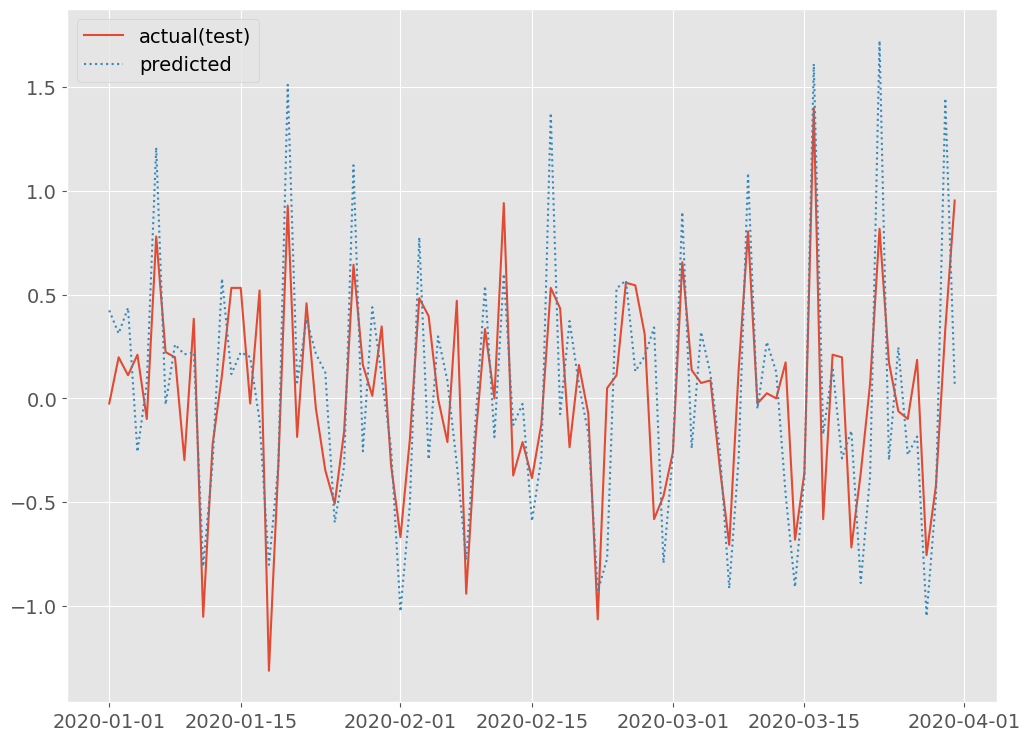

In [13]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値
ax.plot(
    y_test.index, 
    y_test.values, 
    linestyle='-',
    label='actual(test)')

# 予測値
ax.plot(
    y_test.index, 
    xgb_pred, 
    linestyle=':',
    label="predicted") 

# 凡例表示
ax.legend()

plt.show()


# optuna(xgb)

In [14]:
# Optunaの目的関数の設定
def objective(trial):
    
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 10, 10000),
    'max_depth': trial.suggest_int('max_depth', 2, 10, log=True),
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),  
    'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),  
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
}
    
    #モデルのインスタンス生成
    regressor = xgb.XGBRegressor(**params)
    
    #時系列CV
    ##CVのインスタンス生成　
    tss = TimeSeriesSplit(test_size=91)
    ##CVの結果を格納するハコ
    cv_rmse = []
    ##CVの実行
    for fold, (train_index, valid_index) in enumerate(tss.split(X_train)):
        
        #データ分割
        ##訓練データ
        X_train_data = X_train.iloc[train_index].copy() #説明変数
        y_train_data = y_train.iloc[train_index].copy() #目的変数
        ##検証データ
        X_valid_data = X_train.iloc[valid_index].copy() #説明変数
        y_valid_data = y_train.iloc[valid_index].copy() #目的変数
        
        #学習
        regressor.fit(X_train_data, y_train_data)
        # 学習データのコピー
        y_train_new = y_train.copy()
        
        # 説明変数Xを更新しながら予測を実施
        for i in range(len(y_test)):
            
            #当期の予測の実施
            X_value =  X_test.iloc[i:(i+1),:]
            y_value_pred = regressor.predict(X_value)
            y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
            y_train_new = pd.concat([y_train_new,y_value_pred])
            
            #次期の説明変数Xの計算
            lag1_new = y_train_new.iloc[-1] #lag1
            lag7_new = y_train_new.iloc[-7] #lag1
            window7_new = y_train_new[-7:].mean() #window7
            expanding_new = y_train_new.mean() #expanding
            
            #次期の説明変数Xの更新
            X_test.iloc[(i+1):(i+2),1] = lag1_new
            X_test.iloc[(i+1):(i+2),2] = lag7_new
            X_test.iloc[(i+1):(i+2),3] = window7_new
            X_test.iloc[(i+1):(i+2),4] = expanding_new
            
        # 予測値の代入
        test_pred = y_train_new[-91:]
    
        #精度評価（RMSE）
        val_rmse = np.sqrt(mean_squared_error(y_valid_data, test_pred))
        cv_rmse.append(val_rmse)
    
    return np.mean(cv_rmse)

In [15]:
# ハイパーパラメータの探索の実施
sampler = optuna.samplers.TPESampler(seed=123)
study = optuna.create_study(sampler=sampler, direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2024-01-29 00:56:56,034] A new study created in memory with name: no-name-f8fd2ee7-7228-4140-b7d6-03e6291770c1
[I 2024-01-29 00:57:09,370] Trial 5 finished with value: 0.6420721103586772 and parameters: {'n_estimators': 1337, 'max_depth': 4, 'learning_rate': 0.1569814901355964, 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 5 with value: 0.6420721103586772.
[I 2024-01-29 00:57:17,533] Trial 2 finished with value: 0.6068112580697583 and parameters: {'n_estimators': 3040, 'max_depth': 7, 'learning_rate': 0.34042138197299954, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 2 with value: 0.6068112580697583.
[I 2024-01-29 00:57:22,326] Trial 6 finished with value: 0.7108958381789192 and parameters: {'n_estimators': 1280, 'max_depth': 2, 'learning_rate': 0.2699776783762932, 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 2 with value: 0.6068112580697583.
[I 2024-01-29 00:57:32,808] Trial 1 finished with value: 0.6249632831766492 and parameters: {'n_estimator

In [16]:
# 最適解の出力
print(study.best_params)

{'n_estimators': 4289, 'max_depth': 2, 'learning_rate': 0.0014202002035857326, 'subsample': 0.7, 'colsample_bytree': 0.5}


In [17]:
regressor = xgb.XGBRegressor(**study.best_params, random_state=123)
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0014202002035857326,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4289, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [18]:
# 特徴量重要度（Feature Importances）
df_importance = pd.DataFrame(zip(X_train.columns, regressor.feature_importances_),
                             columns=["Features","Importance"])
df_importance = df_importance.sort_values("Importance",
                                          ascending=False)
df_importance #確認

,Features,Importance
7,dow,0.151372
0,call_num,0.136258
12,holiday_flag,0.111144
11,day_before_holiday_flag,0.097036
15,isSunday,0.065280
3,acc_get_cnt_window7,0.060309
2,acc_get_cnt_lag7,0.056100
1,acc_get_cnt_lag1,0.049608
4,acc_get_cnt_expanding,0.045076
14,search_cnt,0.040455


In [19]:
train_pred = regressor.predict(X_train)

In [20]:
# 学習データのコピー
y_train_new = y_train.copy()

# 説明変数Xを更新しながら予測を実施
for i in range(len(y_test)):
    
    #当期の予測の実施
    X_value =  X_test.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #次期の説明変数Xの計算
    lag1_new = y_train_new.iloc[-1] #lag1
    lag7_new = y_train_new.iloc[-7] #lag1
    window7_new = y_train_new[-7:].mean() #window7
    expanding_new = y_train_new.mean() #expanding
    
    #次期の説明変数Xの更新
    X_test.iloc[(i+1):(i+2),1] = lag1_new
    X_test.iloc[(i+1):(i+2),2] = lag7_new
    X_test.iloc[(i+1):(i+2),3] = window7_new
    X_test.iloc[(i+1):(i+2),4] = expanding_new
    
# 予測値の代入
oxgb_pred = y_train_new[-91:]
    
# 更新後の説明変数X
print(X_test)

            call_num  acc_get_cnt_lag1  acc_get_cnt_lag7  acc_get_cnt_window7  \
cdr_date                                                                        
2020-01-01  0.000000         -0.235352          0.173340            -0.107910   
2020-01-02  0.000000          0.103844          0.222920            -0.117856   
2020-01-03  0.216919          0.175942         -0.037153            -0.124567   
2020-01-04 -0.216919          0.035616         -0.854528            -0.114172   
2020-01-05  0.000000         -0.337661          0.086691            -0.040333   
...              ...               ...               ...                  ...   
2020-03-27  0.108459          0.014510         -0.269860             0.032069   
2020-03-28 -1.059570         -0.208135         -0.352096             0.040887   
2020-03-29  0.000000         -0.594925         -0.178467             0.006198   
2020-03-30  1.118164         -0.178821          0.850498             0.006147   
2020-03-31 -0.275391        

In [21]:
print('R2   ＝ ', r2_score(y_test, oxgb_pred).round(decimals=3))
print('MAE  ＝ ', mean_absolute_error(y_test, oxgb_pred).round(decimals=3))
print('MSE  ＝ ', mean_squared_error(y_test, oxgb_pred).round(decimals=3))
print('RMSE ＝ ', np.sqrt(mean_squared_error(y_test, oxgb_pred)).round(decimals=3))

R2   ＝  0.629
MAE  ＝  0.229
MSE  ＝  0.087
RMSE ＝  0.295


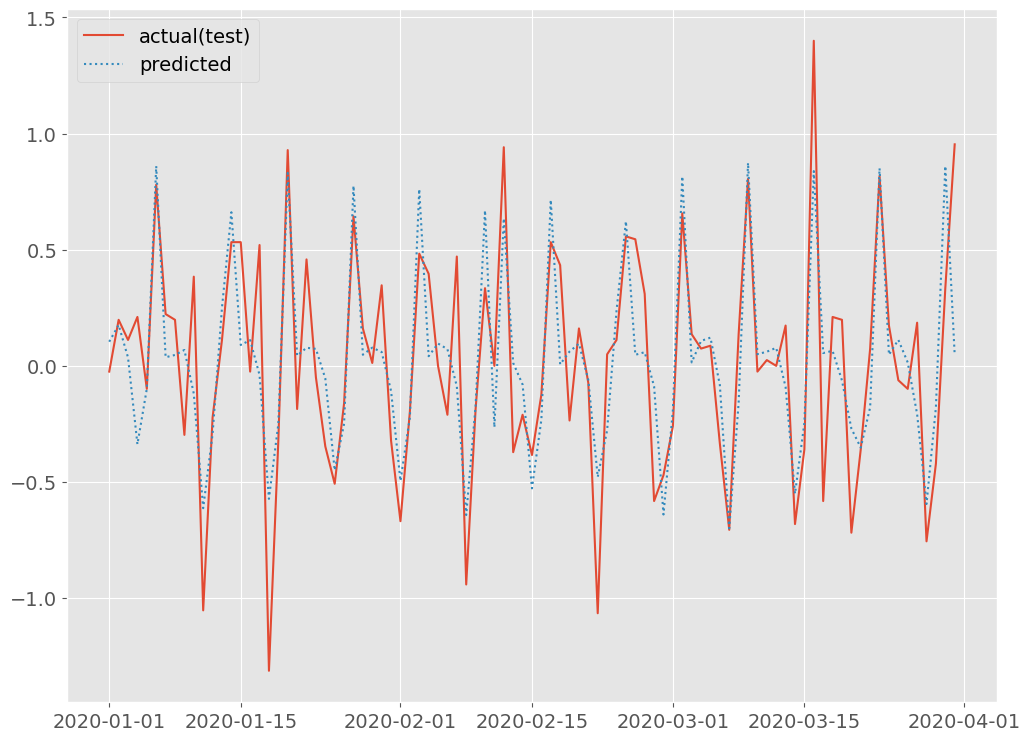

In [22]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値
ax.plot(
    y_test.index, 
    y_test.values, 
    linestyle='-',
    label='actual(test)')

# 予測値
ax.plot(
    y_test.index, 
    oxgb_pred, 
    linestyle=':',
    label="predicted") 

# 凡例表示
ax.legend()

plt.show()


In [24]:
oxgb_pred_reset = oxgb_pred.reset_index()  # インデックスをリセットし、データフレームに変換する

# CSVファイルに書き出す
oxgb_pred_reset.to_csv('xgb_pred.csv', index=False)  